In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing     # For StandardScaler
import sklearn.linear_model      # For LogisticRegression
import sklearn.neural_network    # For MLPClassifier
import torch
import warnings
import os
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)  # Annoying
np.set_printoptions(precision=3, suppress=True)  # Print as 0.001 instead of 9.876e-4

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd ..

%cd /content/drive/MyDrive/Dataset 2/Prostate Cancer
import shutil

# Set the source folder and destination folder paths
source_folder2 = '/content/drive/MyDrive/Dataset 2/Prostate Cancer'
# path to your dataset
destination_folder2 = '/content/Dataset 2'

import os

# Remove the existing folder if it exists
if os.path.exists(destination_folder2):
    shutil.rmtree(destination_folder2)

# Copy the dataset to the destination folder
shutil.copytree(source_folder2, destination_folder2)





/content
/content/drive/MyDrive/Dataset 2/Prostate Cancer


'/content/Dataset 2'

In [3]:

%cd /content/Dataset 2


# List files in the destination folder
os.listdir(destination_folder2)


/content/Dataset 2


['nongland']

In [5]:
# Check the number of .tif files and missing data
expected_count = 6000  # Replace with the expected count

# List all .jpg files in the dataset directory
all_jpg_files = []
for root, dirs, files in os.walk(destination_folder2):
    jpg_files = [file for file in files if file.endswith('.jpg')]
    all_jpg_files.extend(jpg_files)

unique_jpg_files = list(set(all_jpg_files))
print(f"Total .jpg images found: {len(unique_jpg_files)}")

# Remove jpg duplicates in Dataset 1
filtered_jpg_files = [file for file in unique_jpg_files if "(1)" not in file and "(2)" not in file]


# Calculate the total count of .tif files after removing duplicates
total_count = len(filtered_jpg_files)


# Print the results
print(f"Total unique .jpg images found: {total_count}")
print(f"Expected count: {expected_count}")
print(f"Missing data: {expected_count - total_count} files are missing.")


Total .jpg images found: 6000
Total unique .jpg images found: 6000
Expected count: 6000
Missing data: 0 files are missing.


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# List all image files in the dataset directory
image_paths = []
for root, dirs, files in os.walk(destination_folder2):
    for file in files:
        image_paths.append(os.path.join(root, file))

# Define mean and std values for image normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


In [7]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot
from matplotlib import image
import time

# Load and preprocess the data
def load_data(path, test_split,batch_size,input_size):
  #Normalization
   transform_dict = {
      'scr': transforms.Compose(
      [ transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
      ])}
   data = datasets.ImageFolder(root=path, transform=transform_dict['scr'])
  # Split the data into train and test
   dataset_size = len(data)
   test_size = int(dataset_size * test_split)
   train_size = dataset_size - test_size

  # Create data loaders
   train_dataset, test_dataset = td.random_split(data, [train_size, test_size])
   train_loader = td.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
   test_loader = td.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
   return train_loader, test_loader

In [8]:
path = destination_folder2
test_split = 0.0
batch_size = 100
input_size = (224, 224)


train_loader2, test_loader2 = load_data(path, test_split, batch_size, input_size)

print(len(train_loader2))
print(len(test_loader2)) # should be 0 images because no traning is happening

60
0


Batch Shape: torch.Size([100, 3, 224, 224])


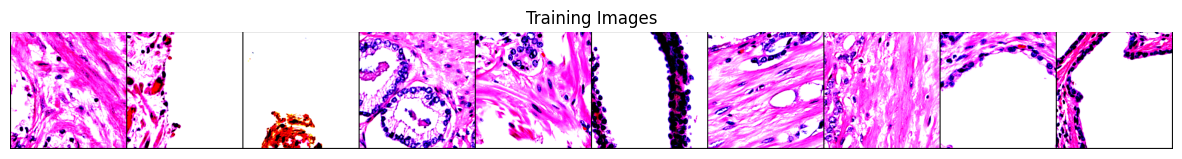

In [9]:
import matplotlib.pyplot as plt
import torchvision

# Display a subset of images
def show_images(images, title, num_images=10):

    grid = torchvision.utils.make_grid(images[:num_images], nrow=num_images)

    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Iterate through one batch from the train_loader
for inputs, labels in train_loader2:
    print(f"Batch Shape: {inputs.shape}")
    show_images(inputs, 'Training Images', num_images=10)
    break


In [10]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
print(device)


# Print the number of samples in training and testing sets

num_batches = len(train_loader2)
print(f"Number of batches in train_loader: {num_batches}")

total_train_samples = num_batches * batch_size
print(f"Total number of samples in the training set: {total_train_samples}")

num_test_batches = len(test_loader2)
print(f"Number of batches in train_loader: {num_test_batches}")

total_test_samples = num_test_batches * batch_size
print(f"Total number of samples in the testing set: {total_test_samples}")





cuda
Number of batches in train_loader: 60
Total number of samples in the training set: 6000
Number of batches in train_loader: 0
Total number of samples in the testing set: 0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Embedded Features Shape: (6000, 2)


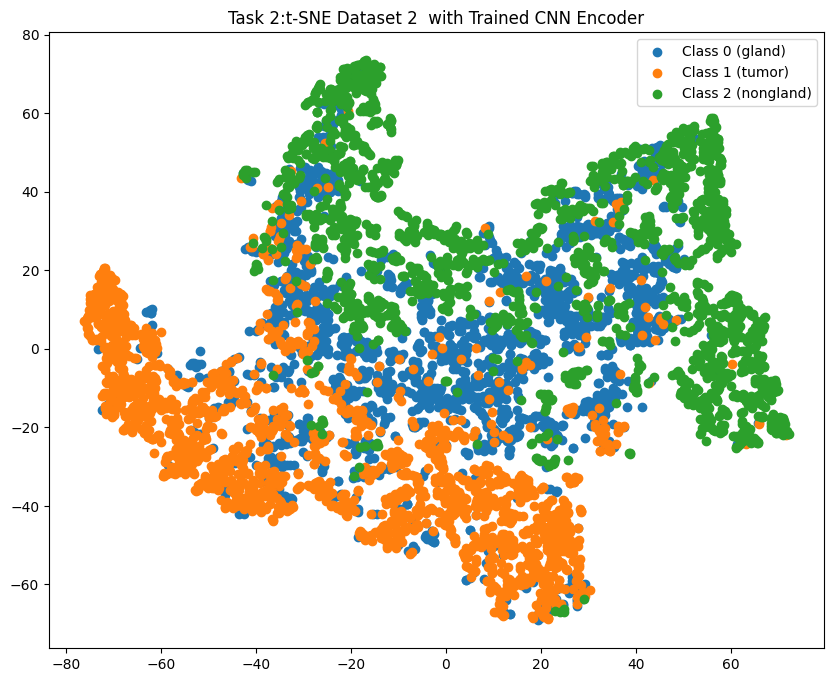

In [11]:
import torch
from torchvision import models
import torch.nn as nn
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class_labels = {0: 'gland', 1: 'tumor', 2: 'nongland'}

num_classes = len(class_labels)

model = models.resnet18(pretrained=False)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Load the trained model
model.load_state_dict(torch.load('/content/drive/MyDrive/resnet18.pt'))
model.to(device)
model.eval()

# Remove the final fully connected layer and the classification layer
model = nn.Sequential(*list(model.children())[:-1])

# Feature extraction loop
feature_vectors = []
true_labels = []

with torch.no_grad():
    for inputs, labels in train_loader2:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        # Flatten the features
        features_flat = outputs.cpu().numpy().reshape(outputs.shape[0], -1)
        feature_vectors.append(features_flat)
        true_labels.append(labels.cpu().numpy())

# Concatenate the 1D features from all batches
feature_vectors = np.concatenate(feature_vectors, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(feature_vectors)

print("Embedded Features Shape:", embedded_features.shape)

flat_true_labels = np.concatenate(true_labels)

# Check for any NaN or infinite values in the embedded features
if np.isnan(embedded_features).any() or np.isinf(embedded_features).any():
    print("NaN or infinite values found in embedded features.")

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    indices = flat_true_labels == i
    plt.scatter(embedded_features[indices, 0], embedded_features[indices, 1], label=f'Class {i} ({class_labels[i]})')


plt.title('Task 2:t-SNE Dataset 2  with Trained CNN Encoder')
plt.legend()
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the data based on the flat_true_labels and embedded features and train knn model
X_train, X_test, y_train, y_test = train_test_split(embedded_features, flat_true_labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict labels on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy for Task 2 Dataset 2: {accuracy*100:.2f}%")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


KNN Accuracy for Task 2 Dataset 2: 87.33%
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       430
           1       0.86      0.88      0.87       368
           2       0.94      0.92      0.93       402

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



In [16]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

#Train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

#Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

#Evaluate the SVM classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy for Task 2 Dataset 2: {accuracy * 100:.2f}%")

#Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVM Accuracy for Task 2 Dataset 2: 66.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.41      0.48       430
           1       0.75      0.87      0.81       368
           2       0.65      0.75      0.70       402

    accuracy                           0.67      1200
   macro avg       0.66      0.68      0.66      1200
weighted avg       0.65      0.67      0.65      1200

